<a href="https://colab.research.google.com/github/jjangmo91/eeSDM_Cervus-nippon/blob/main/eeSDM_Cervus_nippon.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **eeSDM_Cervus-nippon**
이 프로젝트는 Google Earth Engine과 Google Colab을 활용하여 대만꽃사슴(Cervus nippon)의 종분포모델링(Species Distribution Modeling, SDM)을 수행하는 프로젝트입니다. 이 프로젝트는 속리산국립공원에 분포하는 침입종인 대만꽃사슴의 현재 및 미래 서식 가능 지역을 예측하고, 이를 통해 국립공원공단의 생태계 보존 전략 수립에 기여하고자 합니다.


# 1. 데이터 준비 및 전처리
##1.1. 라이브러리 설치 및 Google Earth Engine 초기화

In [13]:
%pip install -U -q eeSDM
%pip install -U -q pyarrow
%pip install -U -q geopandas
%pip install -U -q pycrs
%pip install -U -q statsmodels

In [8]:
import eeSDM
import ee, geemap
import geemap.colormaps as cm

import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import random, math, os

from statsmodels.stats.outliers_influence import variance_inflation_factor

import warnings
warnings.filterwarnings("ignore")

In [9]:
# Earth Engine Authentication
ee.Authenticate()

# Initializing Earth Engine
ee.Initialize(project='ee-jjangmo91')

##1.2. 종 출현 데이터 로드 및 전처리

In [14]:
# Load Species occurence data from CSV
url = "https://raw.githubusercontent.com/jjangmo91/eeSDM_Cervus-nippon/main/Cervus-nippon.csv"

# DataFrame 변환
df = pd.read_csv(url)
print(df.columns)

# Convert DataFrame to GeoDataFrame
gdf = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df.Longitude, df.Latitude), crs = "EPSG:4326")

# Convert GeoDataFrame to Earth Engine object
data_raw = geemap.geopandas_to_ee(gdf)

# Set spatial resolution
grainsize = 30

# Geographic sampling bias 제한(하나 빼고 다 제거)

def remove_duplicates(data_raw, grainsize):
    # Select one occurrence record per pixel at the chosen spatial resolution
    # Generate a random raster image with a seed and reproject it to the specified coordinate system and resolution
    random_raster = ee.Image.random(seed=1234).reproject('EPSG:4326', None, grainsize)

    # Sample presence points with the generated random raster
    # Scale parameter is set to 10 for sampling, geometries are included
    rand_point_vals = random_raster.sampleRegions(collection=ee.FeatureCollection(data_raw), geometries=True)

    # Keep only distinct presence records based on the 'random' property
    return rand_point_vals.distinct('random')

data = remove_duplicates(data_raw, grainsize)

# Before selection and after selection
print("Original data size:", data_raw.size().getInfo())
print("Final data size:", data.size().getInfo())

Index(['Species', 'Latitude', 'Longitude'], dtype='object')
Original data size: 121
Final data size: 116


지리적 샘플링 편향을 전처리 전(파란색)과 전처리 후(빨간색)로 비교한 시각화는 아래와 같습니다. 비교를 용이하게 하기 위해, 지도는 속리산국립공원에서 외래꽃사슴 발생 좌표가 많이 집중된 지역을 중심으로 설정되었습니다.

In [16]:
# Visualization of geographic sampling bias before (blue) and after (red) preprocessing
Map = geemap.Map(layout={"height": "400px", "width": "800px"})

# Add the random raster layer
random_raster = ee.Image.random(seed=1234).reproject("EPSG:4326", None, grainsize)
Map.addLayer(
    random_raster,
    {"min": 0, "max": 1, "palette": ["black", "white"], "opacity": 0.5},
    "Random Raster",
)

# Add the original data layer in blue
Map.addLayer(data_raw, {"color": "blue"}, "Original data")

# Add the final data layer in red
Map.addLayer(data, {"color": "red"}, "Final data")

# Set the center of the map to the coordinates
Map.centerObject(data.geometry(), 12)
Map

Map(center=[36.554703162575194, 127.8572837211205], controls=(WidgetControl(options=['position', 'transparent_…

## 1.3. Define Area of Interest (AOI)

In [17]:
# Define the AOI
aoi = data.geometry().bounds().buffer(distance=50000, maxError=1000)

# Add the AOI to the map
outline = ee.Image().byte().paint(
    featureCollection=aoi, color=1, width=3)

Map.remove_layer("Random Raster")
Map.addLayer(outline, {'palette': 'FF0000'}, "AOI")
Map.centerObject(aoi, 7)
Map

Map(bottom=409957.0, center=[36.52971161769407, 127.85645081415713], controls=(WidgetControl(options=['positio…

## 1.4. 예측 변수 추가 및 다중공선성 제거

In [18]:
# WorldClim BIO Variables V1 (1km): A total of 19 climate variables
BIO = ee.Image("WORLDCLIM/V1/BIO")

# NASA SRTM Digital Elevation 30m: Digital elevation data
Terrain = ee.Algorithms.Terrain(ee.Image("USGS/SRTMGL1_003"))

# MOD44B.006 Terra MODIS Vegetation Continuous Fields Yearly Global 250m
# Percent Tree Cover: Median between 2003 and 2020
MODIS = ee.ImageCollection("MODIS/006/MOD44B")
MedianPTC = MODIS.filterDate('2003-01-01', '2020-12-31').select(['Percent_Tree_Cover'], ['PTC']).median()

# TCC / Global Forest Cover Change(GFCC)
TCC = ee.ImageCollection("NASA/MEASURES/GFCC/TC/v3")
MedianTCC = TCC.filterDate('2000-01-01', '2015-12-31')
MedianTCC = MedianTCC.select(['tree_canopy_cover'], ['TCC']).median()

# Combining Bands into a Single Multi-Band Image
predictors = BIO.addBands(Terrain).addBands(MedianPTC).addBands(MedianTCC)

# 수역 마스크 생성
watermask =  Terrain.select('elevation').gt(0)

# 해양 픽셀 마스킹 및 관심 영역 클리핑
predictors = predictors.updateMask(watermask).clip(aoi)

모델에 높은 상관관계를 가진 예측 변수가 함께 포함되면 다중공선성 문제가 발생할 수 있습니다. 다중공선성은 모델의 독립 변수들 간에 강한 선형 관계가 있을 때 발생하는 현상으로, 모델 계수(가중치) 추정의 불안정을 초래합니다. 이러한 불안정성은 모델의 신뢰성을 감소시키고, 새로운 데이터에 대한 예측이나 해석을 어렵게 만들 수 있습니다. 따라서 우리는 다중공선성을 고려하고 예측 변수를 선택하는 과정을 진행할 것입니다.먼저, 5,000개의 무작위 점을 생성한 후, 해당 지점에서 단일 멀티밴드 이미지의 예측 변수 값을 추출할 것입니다.

In [19]:
# Generate 5,000 random points
data_cor = predictors.sample(scale=grainsize, numPixels=5000, geometries=True)

# Extract predictor variable values
pvals = predictors.sampleRegions(collection=data_cor, scale=grainsize)

추출된 예측 변수 값을 각 포인트에 대해 DataFrame으로 변환한 후 첫 번째 행을 확인할 것입니다.

In [20]:
# Converting predictor values from Earth Engine to a DataFrame
pvals_df = geemap.ee_to_df(pvals)
pvals_df.head(1)

# Displaying the columns
columns = pvals_df.columns
print(columns)

Index(['PTC', 'TCC', 'aspect', 'bio01', 'bio02', 'bio03', 'bio04', 'bio05',
       'bio06', 'bio07', 'bio08', 'bio09', 'bio10', 'bio11', 'bio12', 'bio13',
       'bio14', 'bio15', 'bio16', 'bio17', 'bio18', 'bio19', 'elevation',
       'hillshade', 'slope'],
      dtype='object')


주어진 예측 변수들 간의 스피어만 상관 계수를 계산하고, 이를 히트맵으로 시각화합니다. / 상관관계를 분석하는 방법은 여러가지가 있음, Pearson, Spearman, Kendall's tau 등 여기서 필요한 독립변수 선택, 그리고 fearture 변환과 연계하여 수정 필요

In [21]:
def plot_correlation_heatmap(dataframe, h_size=10, show_labels=False):
    # Calculate Spearman correlation coefficients
    correlation_matrix = dataframe.corr(method="spearman")

    # Create a heatmap
    plt.figure(figsize=(h_size, h_size-2))
    plt.imshow(correlation_matrix, cmap='coolwarm', interpolation='nearest')

    # Optionally display values on the heatmap
    if show_labels:
        for i in range(correlation_matrix.shape[0]):
            for j in range(correlation_matrix.shape[1]):
                plt.text(j, i, f"{correlation_matrix.iloc[i, j]:.2f}",
                         ha='center', va='center', color='white', fontsize=8)

    columns = dataframe.columns.tolist()
    plt.xticks(range(len(columns)), columns, rotation=90)
    plt.yticks(range(len(columns)), columns)
    plt.title("Variables Correlation Matrix")
    plt.colorbar(label="Spearman Correlation")
    plt.savefig('correlation_heatmap_plot.png')
    plt.show()

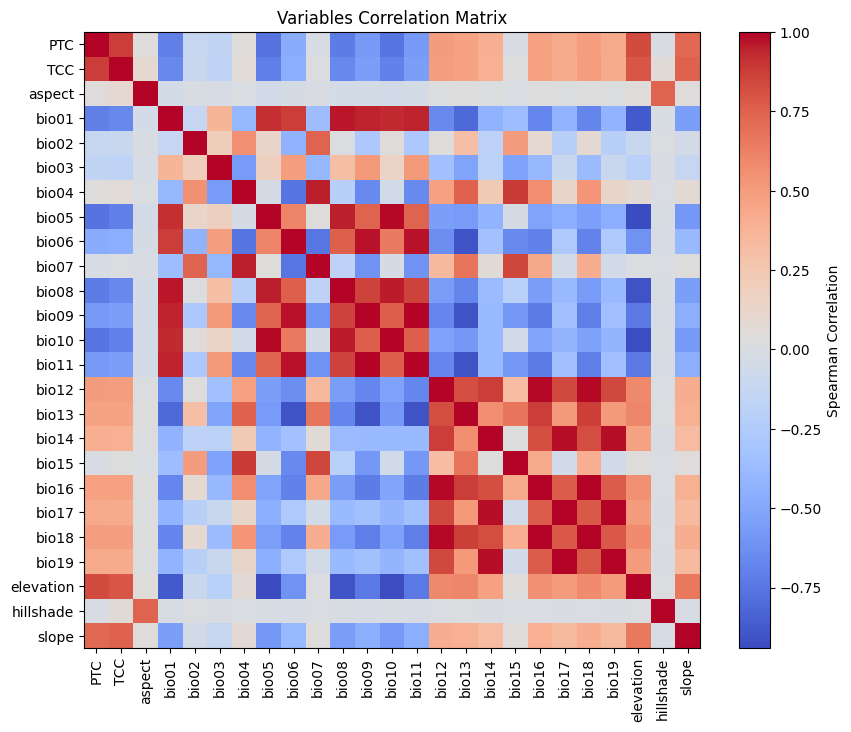

In [22]:
# Plot the correlation heatmap of variables
plot_correlation_heatmap(pvals_df)

스피어만 상관 계수는 예측 변수들 간의 일반적인 연관성을 이해하는 데 유용하지만, 다중공선성을 구체적으로 감지하는 것과는 다르게 여러 변수들의 상호작용을 직접적으로 평가하지는 않습니다.분산 팽창 계수(Variance Inflation Factor, VIF)는 다중공선성을 평가하고 변수 선택을 안내하는 데 사용되는 통계적 지표입니다. VIF는 각 독립 변수가 다른 독립 변수들과 얼마나 선형적으로 연관되어 있는지를 나타내며, 높은 VIF 값은 다중공선성의 증거가 될 수 있습니다.일반적으로 VIF 값이 5 또는 10을 초과하면 해당 변수가 다른 변수들과 강한 상관관계를 가지며, 이는 모델의 안정성과 해석 가능성을 저해할 수 있음을 시사합니다. 여기서는 VIF 값이 10 미만인 변수를 선택하는 기준을 사용했습니다.

In [24]:
def filter_variables_by_correlation_and_vif(dataframe, vif_threshold=10, correlation_threshold=0.8):
    original_columns = dataframe.columns.tolist()

    # Calculate Pearson correlation matrix
    correlation_matrix = dataframe.corr(method="pearson")

    # Find pairs of variables with high correlation
    high_corr_pairs = [
        (i, j) for i in range(correlation_matrix.shape[0])
               for j in range(i + 1, correlation_matrix.shape[1])
               if abs(correlation_matrix.iloc[i, j]) >= correlation_threshold
    ]

    remaining_columns = original_columns[:]

    # Track removed columns to avoid IndexError
    removed_columns = set()

    # Remove one variable from each pair of highly correlated variables
    for i, j in high_corr_pairs:
        col_i = original_columns[i]
        col_j = original_columns[j]

        if col_j in remaining_columns and col_j not in removed_columns:
            print(f"Removing '{col_j}' due to high correlation with '{col_i}' ({correlation_matrix.loc[col_i, col_j]:.2f})")
            remaining_columns.remove(col_j)
            removed_columns.add(col_j)

    # Filter the dataframe to keep only remaining columns after correlation check
    filtered_data = dataframe[remaining_columns]

    # Calculate VIF and filter based on VIF threshold
    while True:
        vif_data = filtered_data[remaining_columns]
        vif_values = [
            variance_inflation_factor(vif_data.values, i)
            for i in range(vif_data.shape[1])
        ]

        max_vif_index = vif_values.index(max(vif_values))
        max_vif = max(vif_values)

        if max_vif < vif_threshold:
            break

        col_to_remove = remaining_columns[max_vif_index]
        print(f"Removing '{col_to_remove}' with VIF {max_vif:.2f}")
        remaining_columns.remove(col_to_remove)

    filtered_data = dataframe[remaining_columns]
    bands = filtered_data.columns.tolist()
    print("Bands:", bands)

    return filtered_data, bands

In [25]:
filtered_pvals_df, bands = filter_variables_by_vif(pvals_df)

Removing 'bio05' with VIF inf
Removing 'bio09' with VIF inf
Removing 'bio17' with VIF inf
Removing 'bio04' with VIF 552641.24
Removing 'bio16' with VIF 537857.82
Removing 'bio07' with VIF 276581.37
Removing 'bio10' with VIF 157971.27
Removing 'bio12' with VIF 114869.47
Removing 'bio08' with VIF 34894.61
Removing 'bio15' with VIF 23376.98
Removing 'bio02' with VIF 19328.31
Removing 'bio19' with VIF 5140.46
Removing 'bio18' with VIF 4140.21
Removing 'bio06' with VIF 3412.89
Removing 'bio13' with VIF 2102.13
Removing 'bio03' with VIF 1456.22
Removing 'bio14' with VIF 125.14
Removing 'hillshade' with VIF 40.09
Removing 'PTC' with VIF 22.36
Removing 'elevation' with VIF 11.70
Bands: ['TCC', 'aspect', 'bio01', 'bio11', 'slope']


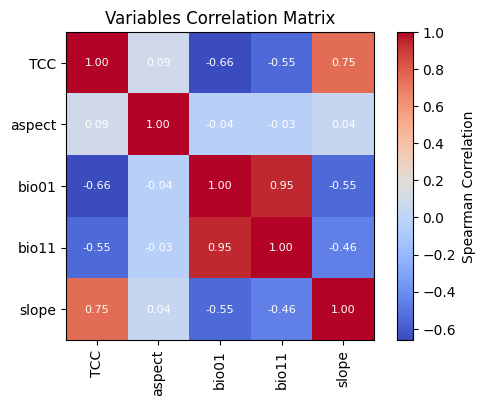

In [26]:
# Variable Selection Based on VIF
predictors = predictors.select(bands)

# Plot the correlation heatmap of variables
plot_correlation_heatmap(filtered_pvals_df, h_size=6, show_labels=True)

다음으로, 선택된 예측 변수를 지도에 시각화해봅니다.

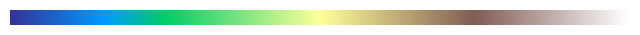

In [27]:
cm.plot_colormap('terrain', width=8.0, height=0.2, orientation='horizontal')

In [28]:
# Calculate the minimum and maximum values for bio01
min_max_val = (
    predictors.select("bio01")
    .multiply(0.1)
    .reduceRegion(reducer=ee.Reducer.minMax(), scale=1000)
    .getInfo()
)

# bio01 (Mean temperature) layer
Map = geemap.Map(layout={"height": "400px", "width": "800px"})

vis_params = {
    "min": math.floor(min_max_val["bio01_min"]),
    "max": math.ceil(min_max_val["bio01_max"]),
    "palette": cm.palettes.hot,
}
Map.addLayer(predictors.select("bio01").multiply(0.1), vis_params, "bio01")
Map.add_colorbar(
    vis_params,
    label="Mean temperature of driest quarter (℃)",
    orientation="vertical",
    layer_name="bio01",
)
Map.centerObject(aoi, 8)
Map

Map(center=[36.52971161769407, 127.85645081415713], controls=(WidgetControl(options=['position', 'transparent_…

In [29]:
# Slope layer
Map = geemap.Map(layout={'height':'400px', 'width':'800px'})

vis_params = {'bands':['slope'], 'min': 0, 'max': 25, 'palette': cm.palettes.RdYlGn_r}
Map.addLayer(predictors, vis_params, 'slope')
Map.add_colorbar(vis_params, label="Slope", orientation="vertical", layer_name="slope")
Map.centerObject(aoi, 8)
Map

Map(center=[36.52971161769407, 127.85645081415713], controls=(WidgetControl(options=['position', 'transparent_…

In [30]:
# Aspect layer
Map = geemap.Map(layout={'height':'400px', 'width':'800px'})

vis_params = {'bands':['aspect'], 'min': 0, 'max': 360, 'palette': cm.palettes.rainbow}
Map.addLayer(predictors, vis_params, 'aspect')
Map.add_colorbar(vis_params, label="Aspect", orientation="vertical", layer_name="aspect")
Map.centerObject(aoi, 8)
Map

Map(center=[36.52971161769407, 127.85645081415713], controls=(WidgetControl(options=['position', 'transparent_…

In [31]:
# TCC layer
Map = geemap.Map(layout={"height": "400px", "width": "800px"})

vis_params = {
    "bands": ["TCC"],
    "min": 0,
    "max": 100,
    "palette": ["ffffff", "afce56", "5f9c00", "0e6a00", "003800"],
}
Map.addLayer(predictors, vis_params, "TCC")
Map.add_colorbar(
    vis_params, label="Tree Canopy Cover (%)", orientation="vertical", layer_name="TCC"
)
Map.centerObject(aoi, 8)
Map


Map(center=[36.52971161769407, 127.85645081415713], controls=(WidgetControl(options=['position', 'transparent_…

# 2. MaxEnt모델 설정 및 학습
SDM은 여러가지 접근 방법이 있습니다. 여기서는 Presence only models로 Presence/background 모델 적합 및 해석 방식인 Maxent를 사용합니다.

Maxent는 presence/background 모델임, 이는 종이 존재하는 위치에 대한 데이터를 사용하고, 종이 부재한 위치 데이터 대신 경관에서 종이 발견될 가능성이 있는 무작위 샘플을 사용함. 이 방법은 데이터 수집 요구 사항을 줄여주지만, 모델 적합과 해석에 있어 약간의 문제가 있..

species occurrence records (y = 1) randomly sampled "background" location records (y = 0) environmental covariate data (x) for each location of y

위의 방법으로 서식지 적합성(the fundamental niche)을 추정

Maxent에서 presence/background 데이터와 환경 공변량 간의 관계를 직접 추정하지 않음(단순히 y ~ x가 아님) 대신, 공변량 데이터에 feature 변환을 적용함 (z = f(x))

예를 들어 이차변환을 계산하거나, 각 공변량의 쌍곱을 계산하는 방식임 다음과 같이 주어진 환경조건에서 종을 반견할 조건부 확률을 추정함 P(species presence | environmental conditions) = feature transformations(x) 이는 다음과 같이 해석할 수 있는데, 경관에서 종을 관찰할 상대적 가능성은 종이 발견된 환경 조건 분포와 경관 전체에서 무작위로 샘플링된 조건 분포 간의 차이에 의해 결정됨

null model은 종이 경관 전체에 균일하게 분포될 가능성이 있다고 가정하는데 Maxent는 이 null model, 즉 "배경" 조건을 사전 확률 분포로 사용하여 종이 관찰된 조건을 기반으로 상대적 적합성을 추정함

두 가지 주요한 기능

feature fitting
fitting models elapid 에서는 한 번에 수행한다
Feature transformations model = elapid.MaxentModel( feature_types=['linear', 'hinge', 'product'], # 피처 변환 tau=0.5, # 발생률 스케일러 clamp=True, # 훈련 데이터 범위 기반의 공변량 최소/최대 설정 scorer='roc_auc', # 최적화할 메트릭 (sklearn.metrics.SCORERS에서) beta_multiplier=1.5, # 정규화 스케일러 (높은 값은 더 많은 피처 제거) beta_lqp=1.0, # 선형, 이차, 곱 정규화 스케일러 beta_hinge=1.0, # 힌지 정규화 스케일러 beta_threshold=1.0, # 임계값 정규화 스케일러 beta_categorical=1.0, # 범주형 정규화 스케일러 n_hinge_features=10, # 계산할 힌지 피처 수 n_threshold_features=10, # 계산할 임계값 피처 수 convergence_tolerance=1e-07, # 모델 적합 수렴 임계값 use_lambdas='best', # 'best' (최소 과적합), 'last' (최고 점수) n_cpus=4, # 사용할 CPU 코어 수 )

elapid는 "r에서 maxnet" 기반으로 작성 됨 sample weights, lambda scores, regularization scores, feature transformations 수치적으로 동일 함

정규화 매개변수, 즉 베타 값은 feature별로 추정되며, 특정 피처가 의미 있는 것으로 모델에 의해 식별될 가능성을 결정함

정규화는 의미 없는 feature나 노이즈가 있는 feature를 제거하여 과적합을 줄이는 데 자주 사용됨 정규화 값을 증가시키면 feature 패널티가 증가하고 모델의 일반화 가능성이 높아짐

Opinionated default model parameters beta_multiplier: 1.5 -

/ 자료를 학습데이터와 테스트데이터로 나눕니다. 비율 찾아보고 설정하기? k-fold-validation(정의/논문 찾기)

머신러닝 모델의 성능을 높이기 위해(과적합 방지) 교차 검증을 수행합니다. 학습 데이터셋(train set)과 테스트 데이터셋(test set)으로 나눕니다. // 어떤 메서드 사용할지 찾아봐야 함

총 데이터 갯수가 적은 데이터 셋에 대하여 정확도를 향상시킬수 있음(적음의 정도에 대해 알야봐야 함)

기존 training / validation / test 세 개의 집단으로 분류하는 것보다, trainging, test로만 분류할 때 학습 데이터 셋이 더 많기 때문

데이터 수가 적은데 검증과 테스트에 데이터를 더 뺏기면 underfitting 등 성능이 미달되는 모델이 학습 됨

test set을 가지고만 모델의 성능을 확인하고, 파라미터를 수정하고 이 과정을 반복하면 머신러닝에서 test set만 학습하여, 실제의 다른 데이터를 가지고 예측을하게 되면 overfitting의 문제가 발생하게 되므로 과적합 방지를 위해 교차 검증이 필요함

교차검증?

주어진 데이터셋에 학습된 알고리즘이 얼마나 잘 일반화되어있는지 평가하기 위한 방법

데이터를 여러 번 반복해서 나누고 여러 번 모델 학습과 검증 과정을 거침, 데이터셋 내의 모든 데이터를 훈련에 활용할 수 있으며, 모델 성능과 정확도를 더 향상시킬 수 있음, 좀 더 일반화된 모델을 만들 수 있음.

부족한 데이터로인한 underfittting을 방지할 수 있고, test set이 편중되는 것을 방지할 수 있음

교차검증 방법도 종류가 많음 대표적인 것은 k-fold cross validation 이 외에 stratified k-kold cross validation, Leave One Out Corss validation, Repeated eandom sub sampling validation, nested cross validation, timeseries cross validation 등

train set를 k개의 fold set로 만들어주고 k개의 fold set를 train set과 validation set로 나누게 됨 k-1개를 train set, 1개를 validation set으로 설정하여 검증 평가를 진행, k개의 fold set에 대해 차례로 validation set을 변경하여 k번의 검증을 수행 함

모델을 학습한 뒤, k번의 성능 평가 결과를 평균하여 최종 모델 성능을 구함

CV를 사용하는 가장 큰 이유는 하이퍼파라미터 튜닝인데, 하나의 validation set을 잘 맞추기 위한 튜닝이 아니라 다른 validation set을 잘 맞추기 위한 튜닝을 하기 때문에 과적합을 피하는 학습을 할 수 있음

통상적으로 k는 5, 10을 많이 사용하는데, 중요한 것은 k가 적어질 수록 bias는 커질 것이고 k가 커진다면 variance가 커짐. 또한 시간도 많이 걸림

데이터가 랜덤하게 k개로 쪼개짐... 클래스가 있는 분류 문제에서는 층화 k-fold CV 사용 회귀 문제에서는 K-fold CV를 사용 그러면 로지스틱 회귀 기반은 층화로 봐야하지 않을까? 고민 아니면 Nested Cross validation 이거 좋아보이는데...

각 폴드에 대해 모델을 훈련하고 평가하여 성능을 측정한다. 폴드는 어떻게 구성할까? p + b? 아니면 p or b? feature와 경위도 좌표를 분

MaxEnt에서는 Regularization Multiplier와 Feature Classes 두 가지 하이퍼파라미터를 설정할 수 있다. Regularization Multiplier는 모델의 복잡도를 제어하며, 값이 높을수록 모델이 더 단순해지며 과적합을 방지할 수 있다. Feature Classes는 모델에서 사용할 피쳐의 종류를 결정하는데, 일반적인 클래스로 liear, quadratic, product, threshold, hinge 등이 있으며, 하이퍼파라미터 설정 방법은 grid search, random search 같은 방법을 사용할 수 있다.

각 하이퍼파라미터 조합에 대해 Maxent분류기를 생성하고 훈련을 하며, 교차 검증을 통해 모델의 정확도를 평가하고, 가장 높은 정확도를 가진 하이퍼파라미터 조합을 찾는다.

## 2.1. Presence-Background 데이터 생성

Presence-background 데이터를 설정하고 Maxent 모델을 학습시킵니다.
Maxent 모델은 종의 출현지점(presence points)과 배경지점(background points)을 사용하여 학습합니다. 이는 종이 존재하는 위치와 무작위로 선택된 위치를 비교하여 서식지 적합성을 모델링하는 방법입니다.

배경지점 background points는 Maxent 모델에서 중요한 역할을 합니다.
Maxent 모델은 Pesence-only data와 background data를 사용하여 종 분포를 예측합니다. 이를 통해 종이 특정 환경 조건에서 나타날 가능성을 평가합니다. background points는 주로 환경 조건의 전 범위를 반영하기 위해 무작위로 선택됩니다.

그러면 왜 배경 지점이 중요할까요?
모델의 일반화: 배경 지점은 다양한 환경 조건을 포함하므로 모델이 특정 환경에 과적합되지 않도록 도와줍니다.
생태학적 중요성: 생물 종의 분포를 모델링할 때, 종이 존재하지 않는 지점(배경 지점)을 포함하여 다양한 환경 조건을 반영하는 것이 중요합니다. 이는 모델이 종의 실제 서식지를 보다 정확하게 예측할 수 있도록 합니다.

배경 지점의 선택 기준
* 랜덤 샘플링: 배경 지점을 무작위로 선택하는 것은 모든 환경 조건이 균등하게 대표되도록 보장합니다.
* 환경 조건의 다양성: AOI 내의 다양한 환경 조건을 포함하는 배경 지점을 선택함으로써 모델은 종이 나타날 수 있는 모든 가능한 조건을 평가할 수 있습니다.

적절한 배경 포인트와 시드 값 설정
이 결정은 모델의 정확도와 재현성에 영향을 미칠 수 있습니다.
* 적절한 배경 포인트 개수 설정
1. 종 출현 데이터의 크기 고려: 종 출현 데이터의 크기에 비례하여 배경 포인트의 개수를 설정하는 것이 일반적입니다. 보통 출현 데이터의 10 ~ 100배를 사용합니다.
예를 들어, 출현 데이터가 50개라면, 500에서 5000개의 배경 포인트를 고려할 수 있습니다.
2. 모델 복잡도와 데이터 다양성: 더 복잡한 모델이나 환경 변수의 다양성이 큰 경우, AOI가 큰 경우, 더 많은 배경 포인트가 필요할 수 있습니다.
3. 테스트 및 검증: 다양한 배경 포인트 개수로 모델을 학습하고 교차 검증을 통해 최적의 개수를 찾는 것이 좋습니다. 여러 개수를 시도해보고 모델의 성능(AUC, ROC 등)을 평가합니다.

* 적절한 시드 값 설정
1. 재현성: 동일한 결과를 재현할 수 있도록 고정된 시드 값을 사용합니다. 이는 연구나 프로젝트에서 결과의 일관성을 유지하는 데 중요합니다.

2. 랜덤성 평가: 여러 시드 값을 테스트하여 모델 성능의 변화를 평가할 수 있습니다. 이는 특정 시드 값에 의한 편향을 줄이는 데 도움이 됩니다.

In [32]:
# Create presence-background data
# Create presence data: Assign a property 'presence' with value 1 to each occurrence point
presence = data.map(lambda feature: feature.set('presence', 1))
# Create background data: Generate random points in the area of interest (AOI) and assign 'presence' with value 0
background = ee.FeatureCollection.randomPoints(region=aoi, points=5000, seed=42).map(lambda feature: feature.set('presence', 0))
# Combine the presence and background points into a single FeatureCollection
combined_points = presence.merge(background)

# Sample the environmental data at the presence and background points
training_data = predictors.sampleRegions( # predictors: Maxent 모델의 입력으로 사용할 환경 변수 이미지 컬렉션
    collection=combined_points, # sampleRegions 함수는 combined_points에서 각 포인트의 환경 변수 값을 추출
    properties=['presence'], # 추출된 데이터에 presence 속성을 포함 시킴
    scale=grainsize # 샘플링 해상도 설정
)

## 2.2. 학습 및 테스트 데이터 분할

In [33]:
# Split the data into training and testing sets (80-20 split)
training_sample = training_data.randomColumn()
training_set = training_sample.filter(ee.Filter.lt('random', 0.8))
testing_set = training_sample.filter(ee.Filter.gte('random', 0.8))

## 2.3. Maxent 모델 학습

In [34]:
# Create a Maxent classifier
maxent = ee.Classifier.amnhMaxent().setOutputMode('probability') # 출력 모드를 "확률"로 설정함. 이 모드는 각 위치에서 종이 존재할 확률을 예측 함

# Train the model
trained_model = maxent.train(
    features=training_set, # 학습 데이터로 사용할 featureColllection 지정
    classProperty='presence', # 클래스 속성의 이름을 지정하며, 이 속성은 종의 출현 여부를 나타내며 모델이 예측해야 할 목표 변수임(target variable), 종 출현 1,  !출현 0
    inputProperties=bands # 학습에 사용할 환경 변수(밴드) 의 리스트 지정, 이전 단계에서 다중공선성 제거하고 선택된 변수들
)

# 3. 모델 평가
학습된 모델을 평가하고 결과를 분석합니다.
1. 모델 평가: 학습된 모델을 사용하여 테스트 데이터에 대한 예측을 수행합니다.
2. 평가 지표 계산: 모델의 성능을 평가하기 위해 Confusion matrix, accuracy, Kappa coefficeint 등의 지표를 계산합니다.
3. 예측 결과를 지도나 그래프 형태로 시각화하여 종 분포를 분석합니다.
4. 모델의 강점과 약점을 분석하여 개선 방향을 도출합니다.

# 반복적인 수정 과정
모델 성능을 개선하기 위해서는 데이터 준비, 모델 학습, 성능 평가의 각 단계를 반복적으로 수행할 필요가 있습니다. 이를 통해 모델의 예측력을 최적화할 수 있습니다.

1. 데이터 준비 및 전처리 수정:
* 데이터의 질을 높이기 위해 전처리 과정을 개선합니다. 예를 들어, 더 많은 배경 포인트를 추가하거나, 새로운 환경 변수를 포함할 수 있습니다.
* 샘플링 해상도를 조정하여 더 정밀한 데이터를 사용합니다.

2. 모델 하이퍼파라미터 튜닝:
* Maxent 모델의 하이퍼파라미터(정규화 값, 피처 클래스 등)를 조정하여 모델의 성능을 최적화합니다.

* 교차 검증(K-fold cross-validation)을 사용하여 하이퍼파라미터 튜닝을 더욱 신뢰성 있게 수행합니다.

3. 모델 재학습 및 재평가:
* 수정된 데이터와 하이퍼파라미터로 모델을 다시 학습시킵니다.
* 새로운 테스트 데이터에 대한 예측을 수행하고, 평가 지표를 계산합니다.
* 이전 평가 결과와 비교하여 성능이 향상되었는지 확인합니다.

## 3.1. 테스트 데이터 예측

In [38]:
# Classify the testing set
classified = testing_set.classify(trained_model)

# Check presence and background count in testing set
presence_count = testing_set.filter(ee.Filter.eq('presence', 1)).size().getInfo()
background_count = testing_set.filter(ee.Filter.eq('presence', 0)).size().getInfo()

print(f'Presence count in testing set: {presence_count}')
print(f'Background count in testing set: {background_count}')

Presence count in testing set: 26
Background count in testing set: 1000


## 3.2. 평가 지표 계산

In [ ]:
# Calculate accuracy metrics
def get_accuracy_metrics(classified, classProperty='presence'):
    confusion_matrix = classified.errorMatrix(classProperty, 'classification')
    accuracy = confusion_matrix.accuracy().getInfo()
    kappa = confusion_matrix.kappa().getInfo()
    return confusion_matrix, accuracy, kappa

confusion_matrix, accuracy, kappa = get_accuracy_metrics(classified)
print(f'Confusion Matrix: \n{confusion_matrix.getInfo()}')
print(f'Accuracy: {accuracy}')
print(f'Kappa: {kappa}')

Confusion Matrix: 
[[0]]
Accuracy: 0
Kappa: 0


# 4. 모델 성능 최적화
## 4.1. 하이퍼파라미터 튜닝 및 재학습

In [ ]:
# Create a Maxent classifier with different hyperparameters
maxent = ee.Classifier.amnhMaxent().setOutputMode('probability').setParameters({
    'beta_lqp': 0.5,
    'numIterations': 500
})

# Train the model with new hyperparameters
trained_model = maxent.train(features=training_set, classProperty='presence', inputProperties=bands)

# Reclassify the testing set with the new trained model
classified = testing_set.classify(trained_model)

# Recalculate accuracy metrics
confusion_matrix, accuracy, kappa = get_accuracy_metrics(classified)
print(f'Confusion Matrix: \n{confusion_matrix.getInfo()}')
print(f'Accuracy: {accuracy}')
print(f'Kappa: {kappa}')


AttributeError: 'Classifier' object has no attribute 'setParameters'

## 4.2. K-fold 교차 검증

In [ ]:
def k_fold_cross_validation(data, k, model_fn, evaluate_fn):
    folds = data.randomColumn('fold').sort('fold').toList(k)
    metrics = []
    for i in range(k):
        fold = ee.FeatureCollection(folds.get(i))
        training_set = ee.FeatureCollection(folds.slice(0, i).cat(folds.slice(i+1, k)))
        testing_set = fold
        trained_model = model_fn(training_set)
        classified = testing_set.classify(trained_model)
        metrics.append(evaluate_fn(classified))
    avg_metrics = ee.List(metrics).reduce(ee.Reducer.mean())
    return avg_metrics

# Example usage
def model_fn(training_set):
    maxent = ee.Classifier.amnhMaxent().setOutputMode('probability')
    return maxent.train(features=training_set, classProperty='presence', inputProperties=bands)

def evaluate_fn(classified):
    confusion_matrix = classified.errorMatrix('presence', 'classification')
    accuracy = confusion_matrix.accuracy()
    kappa = confusion_matrix.kappa()
    return ee.Dictionary({'accuracy': accuracy, 'kappa': kappa})

avg_metrics = k_fold_cross_validation(training_data, 5, model_fn, evaluate_fn)
print('Average Metrics:', avg_metrics.getInfo())

# 6. 예측 결과 시각화

In [ ]:
# Predict over the entire area
prediction = predictors.classify(trained_model)

# Define visualization parameters
vis_params = {'min': 0, 'max': 1, 'palette': ['blue', 'green']}

# Create a folium map to visualize the prediction
Map = geemap.Map(center=[36.5, 127.5], zoom=8)
Map.addLayer(prediction, vis_params, 'Maxent Prediction')
Map.centerObject(aoi)
Map

# 7. Calculate Variable Importance

# 8. Accuracy Assessment